In [10]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/20e4342de41086d57b759818fe69005d?type=1
# 标题：指数估值自动报表系统——源代码

import os
import sys
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from jqdata import *
plt.rcParams['axes.unicode_minus'] = False 
sns.set(font='serif')

In [11]:
def get_pe_pb(index_code, start_date, end_date=datetime.datetime.now().date()):
    '''获取PE/PB'''
    def iter_pe_pb():
        '''一个获取PE/PB的生成器'''
        trade_date = get_trade_days(start_date=start_date, end_date=end_date)   
        for date in trade_date:
            stocks = get_index_stocks(index_code, date)
            q = query(valuation.pe_ratio, 
                      valuation.pb_ratio
                     ).filter(valuation.pe_ratio != None,
                              valuation.pb_ratio != None,
                              valuation.code.in_(stocks))
            df = get_fundamentals(q, date)
            quantile = df.quantile([0.25, 0.75])
            df_pe = df.pe_ratio[(df.pe_ratio > quantile.pe_ratio.values[0]) &\
                                (df.pe_ratio < quantile.pe_ratio.values[1])]
            df_pb = df.pb_ratio[(df.pb_ratio > quantile.pb_ratio.values[0]) &\
                                (df.pb_ratio < quantile.pb_ratio.values[1])]
            yield date, df_pe.median(), df_pb.median()

    dict_result = [{'date': value[0], 'pe': value[1], 'pb':value[2]} for value in iter_pe_pb()]
    df_result = pd.DataFrame(dict_result)
    df_result.set_index('date', inplace=True)
    return df_result

In [12]:
def loc_pe_pb(index_code):
    '''获取保存在本地的PE/PB数据'''
    file_name = get_security_info(index_code).display_name +'_pe_pb.csv'
    if os.path.exists(file_name):
        df_loc_pe_pb = pd.read_csv(file_name, index_col='date', parse_dates=True)
        return df_loc_pe_pb
    else:
        return pd.DataFrame()

In [13]:
def save_pe_pb(index_code, df_new, df_old=pd.DataFrame()):
    '''将数据保存或更新到本地，避免重复生成计算'''
    file_name = get_security_info(index_code).display_name +'_pe_pb.csv'
    if len(df_old) <= 0:
        df_new.to_csv(file_name)
    else:
        df = df_old.append(df_new)
        df.to_csv(file_name)

In [14]:
def GetPePb(index_code, start_date):
    df_old = loc_pe_pb(index_code)  # 判断本地是否有历史数据
    if len(df_old) <= 0:
        start_date = start_date  # 给定一个默认的起始时间
    else:
        start_date = df_old.index[-1]
    df_new = get_pe_pb(index_code,start_date=start_date)
    save_pe_pb(index_code, df_new=df_new, df_old=df_old)
    return loc_pe_pb(index_code)

In [15]:
def init(index_base=None):
    '''
    初始化数据缓存
    '''
    if index_base == None:
        index_base = ['000016.XSHG', '000300.XSHG', '399905.XSHE']  # 上证50，沪深300，中证500
    dict_index_base = dict()

    '''加载pe/pb'''
    for index in index_base:
        index_info = get_security_info(index) # 获取指数相关信息
        start_date = index_info.start_date  # 上市日期 
        dict_index_base[index] = (GetPePb(index, start_date))  # 加载或重新计算pe/pb
    return dict

In [16]:
def show_quantile(index_code, p, n, data):
    '''
    展示估值图
    '''
    _df = pd.DataFrame()
    df = data.copy()
    df.index.name = None

    # 一、计算当前百分位高度
    _df[p] = df[p]
    _df = _df.iloc[-n * 244:]
    p_high = [_df[p].quantile(i / 10.0) for i in [3, 5, 7]] 
    for p_h, i in zip(p_high, [3, 5, 7]):
        _df[str(i / 10 * 100)+'%'] = p_h

    # 二、计算历史百分位高度
    def _func(c):
        low_p = c[c < c[-1]]
        value = low_p.shape[0] / c.shape[0]
        return value
    _df['history'] = df[p].rolling(n * 244).apply(lambda x: _func(x), raw=True)[-n*244:]

    # 三、计算评估语句
    low_p = _df[_df[p] < _df[p].iloc[-1]]
    quantile_now = low_p.shape[0] / _df.shape[0]  # 当前百分位值
    last_p = _df[p][-1]
    assessment = ''
    if 0 <= quantile_now < 0.1: 
        assessment = '超低估'
    elif 0.1 < quantile_now < 0.3:
        assessment = '低估'
    elif 0.3 < quantile_now < 0.4:
        assessment = '适中偏低'
    elif 0.4 < quantile_now < 0.6:
        assessment = '适中'
    elif 0.6 < quantile_now < 0.7:
        assessment = '适中偏高'   
    elif 0.7 < quantile_now < 0.9:
        assessment = '高估'   
    elif 0.9 < quantile_now <= 1:
        assessment = '超高估'   

    title = '{}，当前{}{}，近{}年历史百分位{}，{}'.format(get_security_info(index_code).display_name, 
                                              p, round(last_p, 2), n, 
                                              str(round(quantile_now * 100, 2)) + '%', assessment)

    _df.plot(secondary_y=['history'], figsize=(18, 10), style=['-', '--', '--', '--', 'y-'], title=title)

In [17]:
def show_quantile2(index_code, p, data):
    '''
    展示估值图
    '''
    fig, _ax = plt.subplots(figsize=(18, 4), ncols=3, nrows=1)
    for n, ax in zip([3, 5, 7], _ax):
        _df = pd.DataFrame()
        df = data.copy()
        df.index.name = None

        # 一、计算当前百分位高度
        _df[p] = df[p]
        _df = _df.iloc[-n * 244:]
        p_high = [_df[p].quantile(i / 10.0) for i in [3, 5, 7]] 
        for p_h, i in zip(p_high, [3, 5, 7]):
            _df[str(i / 10 * 100)+'%'] = p_h

        # 二、计算历史百分位高度
        def _func(c):
            low_p = c[c < c[-1]]
            value = low_p.shape[0] / c.shape[0]
            return value
        _df['history'] = df[p].rolling(n * 244).apply(lambda x: _func(x), raw=True)[-n*244:]

        # 三、计算评估语句
        low_p = _df[_df[p] < _df[p].iloc[-1]]
        quantile_now = low_p.shape[0] / _df.shape[0]  # 当前百分位值
        last_p = _df[p][-1]
        assessment = ''
        if 0 <= quantile_now < 0.1: 
            assessment = '超低估'
        elif 0.1 < quantile_now < 0.3:
            assessment = '低估'
        elif 0.3 < quantile_now < 0.4:
            assessment = '适中偏低'
        elif 0.4 < quantile_now < 0.6:
            assessment = '适中'
        elif 0.6 < quantile_now < 0.7:
            assessment = '适中偏高'   
        elif 0.7 < quantile_now < 0.9:
            assessment = '高估'   
        elif 0.9 < quantile_now <= 1:
            assessment = '超高估'   

        title = '{}，当前{}{}，近{}年历史百分位{}，{}'.format(get_security_info(index_code).display_name, 
                                                  p, round(last_p, 2), n, 
                                                  str(round(quantile_now * 100, 2)) + '%', assessment)

        _df.plot(secondary_y=['history'],  
                 style=['-', '--', '--', '--', 'y-'], 
                 title=title,
                 ax=ax,
                 legend=False)
    _ax[0].legend(loc='best')

In [18]:
def init(index_base=None):
    '''
    初始化数据缓存
    '''
    if index_base == None:
        index_base = ['000016.XSHG', '000300.XSHG', '399905.XSHE']  # 上证50，沪深300，中证500
    dict_index_base = dict()

    '''加载pe/pb'''
    for index in index_base:
        index_info = get_security_info(index) # 获取指数相关信息
        start_date = index_info.start_date  # 上市日期 
        dict_index_base[index] = (GetPePb(index, start_date))  # 加载或重新计算pe/pb
    return dict_index_base

---


In [19]:
dic = init(['000001.XSHG'])

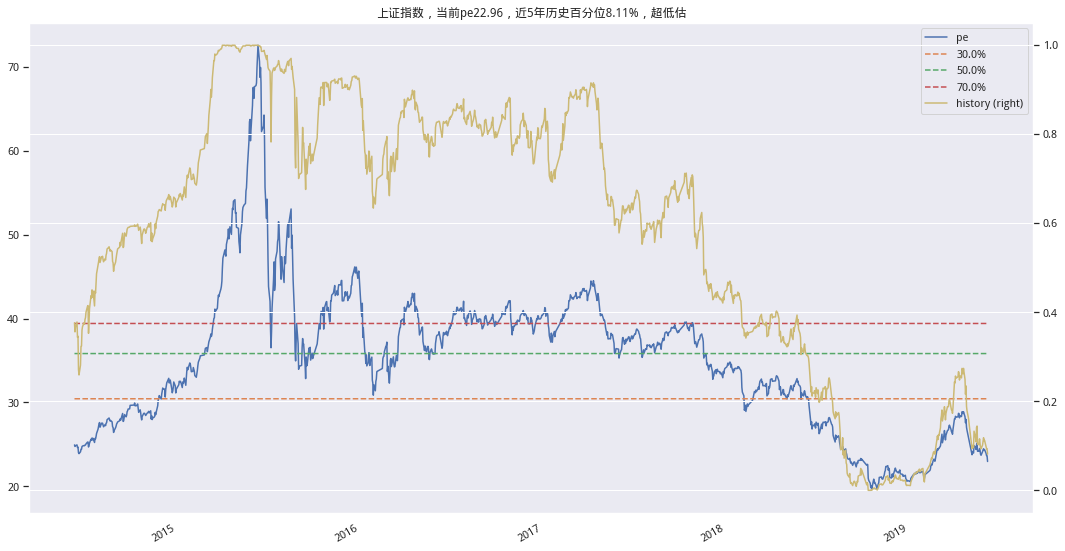

In [22]:
for index, data in dic.items():
    show_quantile(index, 'pe', 5, data)